# Import

In [14]:
!pip install catboost
!pip install joblib

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import joblib

# Data Preprocessing

In [4]:
data = pd.read_csv('pricerunner_aggregate.csv')
data.columns = ['Product ID', 'Product Title', 'Merchant ID', 'Cluster ID', 'Cluster Label', 'Category ID', 'Category Label']

data['Product Title'] = data['Product Title'].str.lower()

In [5]:
unique_category_ids = data['Category ID'].unique()

for i in range(len(unique_category_ids)):
  data['Category ID'] = data['Category ID'].replace({unique_category_ids[i]: i+1})

In [6]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

X_train = train_data['Product Title']
y_train = train_data['Category Label']
X_test, y_test= test_data['Product Title'], test_data['Category Label']

In [7]:
vectorizer = TfidfVectorizer()

X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
X_train_vectorized = pd.DataFrame(X_train_vectorized.toarray(), columns=vectorizer.get_feature_names_out())
X_test_vectorized = pd.DataFrame(X_test_vectorized.toarray(), columns=vectorizer.get_feature_names_out())

# Train

In [ ]:
model_catboost = CatBoostClassifier(iterations=500, loss_function='MultiClass', task_type='GPU', random_seed=42)
model_catboost.fit(X_train_vectorized, y_train)

In [9]:
y_pred = model_catboost.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print(classification_report(y_test, y_pred))

Accuracy: 0.9270848081551748
                  precision    recall  f1-score   support

            CPUs       1.00      0.99      0.99       771
 Digital Cameras       1.00      0.97      0.98       542
     Dishwashers       0.89      0.93      0.91       662
        Freezers       0.98      0.90      0.93       439
 Fridge Freezers       0.94      0.89      0.91      1115
         Fridges       0.87      0.88      0.87       728
      Microwaves       1.00      0.89      0.94       469
   Mobile Phones       0.76      1.00      0.86       818
             TVs       1.00      0.93      0.96       723
Washing Machines       0.99      0.90      0.94       796

        accuracy                           0.93      7063
       macro avg       0.94      0.93      0.93      7063
    weighted avg       0.94      0.93      0.93      7063



In [ ]:
model_tree = DecisionTreeClassifier(random_state=42)
model_tree.fit(X_train_vectorized, y_train)

y_pred = model_tree.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print(classification_report(y_test, y_pred))

In [11]:
model_log = LogisticRegression(max_iter=1000, random_state=42)
model_log.fit(X_train_vectorized, y_train)

y_pred = model_log.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print(classification_report(y_test, y_pred))

Accuracy: 0.9545518901316721
                  precision    recall  f1-score   support

            CPUs       1.00      0.99      1.00       771
 Digital Cameras       0.99      0.99      0.99       542
     Dishwashers       0.89      0.95      0.92       662
        Freezers       0.98      0.91      0.94       439
 Fridge Freezers       0.96      0.92      0.94      1115
         Fridges       0.88      0.92      0.90       728
      Microwaves       1.00      0.94      0.97       469
   Mobile Phones       0.96      1.00      0.98       818
             TVs       0.97      0.98      0.98       723
Washing Machines       0.95      0.94      0.94       796

        accuracy                           0.95      7063
       macro avg       0.96      0.95      0.96      7063
    weighted avg       0.96      0.95      0.95      7063



# Predict new_query

In [12]:
# new_query = "New phone, cool camera, lots of memory, keeps charging for a long time"
new_query = "a new camera model that has a removable lens"
new_query = vectorizer.transform([new_query])

In [13]:
predicted_category_catboost = model_catboost.predict(new_query)
predicted_category_tree = model_tree.predict(new_query)
predicted_category_logreg = model_log.predict(new_query)

print("Predicted Category catboost:", predicted_category_catboost)
print("Predicted Category tree:", predicted_category_tree)
print("Predicted Category logreg:", predicted_category_logreg)

Predicted Category catboost: [['Digital Cameras']]
Predicted Category tree: ['Digital Cameras']
Predicted Category logreg: ['Digital Cameras']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


# Save models

In [18]:
joblib.dump(model_catboost, 'catboost_model.pkl')
joblib.dump(model_tree, 'model_tree.pkl')
joblib.dump(model_log, 'model_log.pkl')

['model_log.pkl']

#EDA

In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Product ID      35311 non-null  int64 
 1   Product Title   35311 non-null  object
 2   Merchant ID     35311 non-null  int64 
 3   Cluster ID      35311 non-null  int64 
 4   Cluster Label   35311 non-null  object
 5   Category ID     35311 non-null  int64 
 6   Category Label  35311 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.9+ MB
None


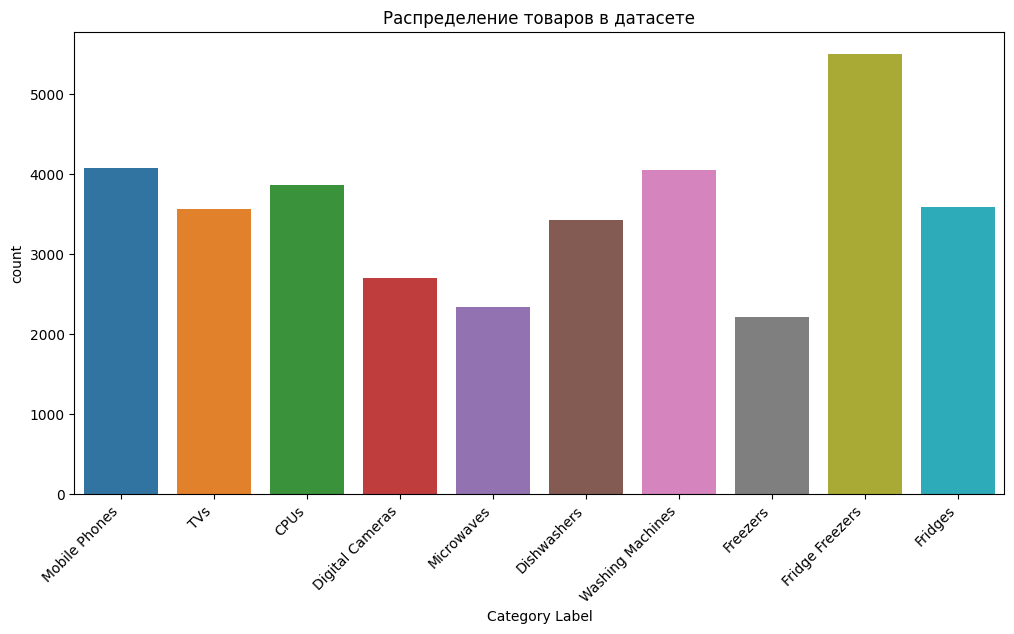

In [ ]:
# Распределение целевой переменной
plt.figure(figsize=(12, 6))
sns.countplot(x='Category Label', data=data)
plt.xticks(rotation=45, ha='right')
plt.title('Распределение товаров в датасете')
plt.show()